# Greater Sydney Analysis – SA4 Blacktown

## 0 Setup

In [42]:
# Python imports
import time, requests
import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine, inspect
import matplotlib.pyplot as plt


# Database connection
DB_URL = "postgresql+psycopg2://root:pg@localhost:5432/gsa"
engine = create_engine(DB_URL, future=True)
inspector = inspect(engine)

with engine.begin() as conn:
    conn.exec_driver_sql("""
        CREATE SCHEMA IF NOT EXISTS raw;
        CREATE SCHEMA IF NOT EXISTS analysis;
    """)

## TASK 1
### 1.1 Load raw data (shapefile & CSV)
Load national SA2 shapefile and raw CSV tables. Skip if tables already exist.

In [3]:
# Paths to raw files
SHAPEFILE = "./data_raw/SA2_2021_AUST_GDA2020/SA2_2021_AUST_GDA2020.shp"
BUSINESSES_CSV = "./data_raw/Businesses.csv"
POP_CSV = "./data_raw/Population.csv"
INCOME_CSV = "./data_raw/Income.csv"
STOPS_TXT = "./data_raw/Stops.txt"
PRIMARY_SHP = "./data_raw/catchments/catchments_primary.shp"
SECONDARY_SHP = "./data_raw/catchments/catchments_secondary.shp"

# Load national SA2 shapefile
if not inspector.has_table("sa2_all", schema="raw"):
    gdf_sa2 = gpd.read_file(SHAPEFILE).to_crs(7844)
    gdf_sa2.to_postgis(
        "sa2_all", engine, schema="raw", if_exists="replace", index=False
    )
    print("Loaded raw.sa2_all")
else:
    print("raw.sa2_all already exists - skipping")

# Load CSV tables
csv_map = {"businesses": BUSINESSES_CSV, "population": POP_CSV, "income": INCOME_CSV}

for name, path in csv_map.items():
    if not inspector.has_table(name, schema="raw"):
        pd.read_csv(path).to_sql(
            name,
            engine,
            schema="raw",
            if_exists="replace",
            index=False,
            chunksize=10000,
        )
        print(f"Loaded raw.{name}")
    else:
        print(f"raw.{name} already exists - skipping")

# Load Stops.txt, build geometry
if not inspector.has_table("stops", schema="raw"):
    stops = pd.read_csv(STOPS_TXT)
    gdf_stops = gpd.GeoDataFrame(
        stops, geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat, crs=4326)
    ).to_crs(7844)
    gdf_stops.to_postgis(
        "stops", engine, schema="raw", if_exists="replace", index=False
    )
    print("Loaded raw.stops")
else:
    print("raw.stops already exists - skipping")

# Load primary‐school catchments
if not inspector.has_table("catchments_primary", schema="raw"):
    gdf_primary = gpd.read_file(PRIMARY_SHP).to_crs("EPSG:7844")
    gdf_primary.to_postgis(
        name="catchments_primary",
        con=engine,
        schema="raw",
        if_exists="replace",
        index=False,
    )
    print("Loaded raw.catchments_primary")
else:
    print("raw.catchments_primary exists — skipping")

# Load secondary‐school catchments
if not inspector.has_table("catchments_secondary", schema="raw"):
    gdf_secondary = gpd.read_file(SECONDARY_SHP).to_crs("EPSG:7844")
    gdf_secondary.to_postgis(
        name="catchments_secondary",
        con=engine,
        schema="raw",
        if_exists="replace",
        index=False,
    )
    print("Loaded raw.catchments_secondary")
else:
    print("raw.catchments_secondary exists — skipping")


Loaded raw.sa2_all
Loaded raw.businesses
Loaded raw.population
Loaded raw.income
Loaded raw.stops
Loaded raw.catchments_primary
Loaded raw.catchments_secondary


### 1.2 Filter to CHOSEN SA4
Create *_my tables limited to the chosen SA4.

In [4]:
with engine.begin() as conn:
    # 1. build one SA2 table for all three SA4s
    conn.exec_driver_sql("""
        DROP TABLE IF EXISTS raw.sa2_my CASCADE;
        CREATE TABLE raw.sa2_my AS
        SELECT
          "SA4_NAME21"   AS sa4_name21,
          "SA2_CODE21"   AS sa2_code21,
          "SA2_NAME21"   AS sa2_name21,
          geometry
        FROM raw.sa2_all
        WHERE "SA4_NAME21" IN (
          'Sydney - North Sydney and Hornsby',
          'Sydney - Eastern Suburbs',
          'Sydney - Blacktown'
        );

        -- spatial index on the geometry
        CREATE INDEX IF NOT EXISTS idx_sa2_my_geom
          ON raw.sa2_my USING gist (geometry);

        -- optional: index on the SA4 column for faster filtering
        CREATE INDEX IF NOT EXISTS idx_sa2_my_sa4
          ON raw.sa2_my (sa4_name21);
    """)

    # 2. Filter each CSV table down to those SA2 codes
    for name in csv_map.keys():
        sa2_col = "sa2_code21" if name == "income" else "sa2_code"
        select_extra = (
            "" 
            if sa2_col == "sa2_code21" 
            else f", t.{sa2_col}::text AS sa2_code21"
        )

        conn.exec_driver_sql(f"""
            DROP TABLE IF EXISTS raw.{name}_my CASCADE;
            CREATE TABLE raw.{name}_my AS
            SELECT t.*{select_extra}
            FROM raw.{name} t
            JOIN raw.sa2_my s
              ON t.{sa2_col}::text = s.sa2_code21;
        """)

    # 3. Spatially filter GTFS stops to those three SA4s
    conn.exec_driver_sql("""
        DROP TABLE IF EXISTS raw.stops_my CASCADE;
        CREATE TABLE raw.stops_my AS
        SELECT s.*, a.sa4_name21
        FROM raw.stops s
        JOIN raw.sa2_my a
          ON ST_Contains(a.geometry, s.geometry);

        CREATE INDEX IF NOT EXISTS idx_stops_my_geom
          ON raw.stops_my USING gist (geometry);
    """)

    # 4. Spatially filter primary & secondary catchments
    conn.exec_driver_sql("""
        DROP TABLE IF EXISTS raw.catchments_primary_my CASCADE;
        CREATE TABLE raw.catchments_primary_my AS
        SELECT c.*, s.sa4_name21
        FROM raw.catchments_primary c
        JOIN raw.sa2_my s
          ON ST_Intersects(s.geometry, c.geometry);
        CREATE INDEX IF NOT EXISTS idx_catchments_primary_my_geom
          ON raw.catchments_primary_my USING gist (geometry);

        DROP TABLE IF EXISTS raw.catchments_secondary_my CASCADE;
        CREATE TABLE raw.catchments_secondary_my AS
        SELECT c.*, s.sa4_name21
        FROM raw.catchments_secondary c
        JOIN raw.sa2_my s
          ON ST_Intersects(s.geometry, c.geometry);
        CREATE INDEX IF NOT EXISTS idx_catchments_secondary_my_geom
          ON raw.catchments_secondary_my USING gist (geometry);
    """)

print("SA2 slice + CSV + stops + catchments all include the three SA4s in raw.sa2_my")  


SA2 slice + CSV + stops + catchments all include the three SA4s in raw.sa2_my


## TASK 2
### 2.1 POI API extraction

In [5]:
LAYER_URL = (
    "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query"
)

FIELD_LIST = ",".join([
    "objectid",
    "poigroup",
    "poitype",
    "poiname",
    "poilabel",
    "poialtlabel",
])


def fetch_poi_bbox(bbox, chunk=1000):
    params = {
        "geometry": ",".join(map(str, bbox)),
        "geometryType": "esriGeometryEnvelope",
        "inSR": 4326,
        "outSR": 4326,
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": FIELD_LIST,
        "returnGeometry": "true",
        "where": "1=1",
        "f": "json",
        "resultRecordCount": chunk,
    }

    records, offset = [], 0
    while True:
        params["resultOffset"] = offset
        resp = requests.get(LAYER_URL, params=params, timeout=40)
        resp.raise_for_status()
        feats = resp.json().get("features", [])
        records.extend(feats)
        if len(feats) < chunk:
            break
        offset += chunk
        time.sleep(0.3)
    return records

### 2.2 Loop through every Blacktown SA2

In [6]:
# Load SA2 polygons and convert to EPSG:4326
sa2 = gpd.read_postgis(
    "SELECT sa2_code21, geometry FROM raw.sa2_my", engine, geom_col="geometry"
).to_crs(4326)

# Define the mapping
POI_GROUP_MAP = {
    1: "Community",
    2: "Education",
    3: "Recreation",
    4: "Transport",
    5: "Utility",
    6: "Hydrography",
    7: "Landform",
    8: "Place",
    9: "Industry",
}
rows = []

for _, row in sa2.iterrows():
    print(f"Fetching POIs for SA2 {row.sa2_code21}")
    feats = fetch_poi_bbox(row.geometry.bounds)

    for f in feats:
        attr = f["attributes"]

        # Some poiname return null
        name = attr.get("poiname") or attr.get("poilabel") or attr.get("poialtlabel")

        # 2. Translate the integer code to a name
        code = attr.get("poigroup")
        grp  = POI_GROUP_MAP.get(code, f"Unknown({code})")

        rows.append(
            {
                "sa2_code21": row.sa2_code21,
                "poi_group":  grp,
                "poi_type": attr.get("poitype"),
                "name": name,
                "longitude": f["geometry"]["x"],
                "latitude": f["geometry"]["y"],
            }
        )

    # wait before next SA2
    time.sleep(1)

print(f"Finished — collected {len(rows):,} POI records")

# print(rows[0])

Fetching POIs for SA2 116011303
Fetching POIs for SA2 116011304
Fetching POIs for SA2 116011306
Fetching POIs for SA2 116011307
Fetching POIs for SA2 116011560
Fetching POIs for SA2 116011561
Fetching POIs for SA2 116011626
Fetching POIs for SA2 116011627
Fetching POIs for SA2 116021309
Fetching POIs for SA2 116021562
Fetching POIs for SA2 116021563
Fetching POIs for SA2 116021628
Fetching POIs for SA2 116021629
Fetching POIs for SA2 116021630
Fetching POIs for SA2 116021631
Fetching POIs for SA2 116021632
Fetching POIs for SA2 116021633
Fetching POIs for SA2 116031313
Fetching POIs for SA2 116031314
Fetching POIs for SA2 116031315
Fetching POIs for SA2 116031316
Fetching POIs for SA2 116031317
Fetching POIs for SA2 116031318
Fetching POIs for SA2 116031319
Fetching POIs for SA2 118011339
Fetching POIs for SA2 118011340
Fetching POIs for SA2 118011341
Fetching POIs for SA2 118011342
Fetching POIs for SA2 118011344
Fetching POIs for SA2 118011345
Fetching POIs for SA2 118011346
Fetching

### 2.3 Ingest Result Into Postgres

In [52]:
# Convert rows to GeoDataFrame
gdf_poi = gpd.GeoDataFrame(
    rows,
    geometry=gpd.points_from_xy(
        [r["longitude"] for r in rows], [r["latitude"] for r in rows]
    ),
    crs="EPSG:4326",
).to_crs("EPSG:7844")

# Filter columns
gdf_poi = gdf_poi[["sa2_code21", "poi_group","poi_type", "name", "geometry"]]


with engine.begin() as conn:
    conn.exec_driver_sql(
        "DROP VIEW IF EXISTS analysis.vw_metric_poi CASCADE;"
    )
# Save to PostGIS
gdf_poi.to_postgis(
    name="poi_my", con=engine, schema="raw", if_exists="replace", index=False
)

# Create spatial index
with engine.begin() as conn:
    conn.exec_driver_sql(
        """
        CREATE INDEX IF NOT EXISTS idx_poi_my_geom
        ON raw.poi_my USING gist (geometry);
    """
    )

print(f"raw.poi_my table created with {len(gdf_poi):,} rows")

raw.poi_my table created with 10,473 rows


## TASK 3
### 3.1 Metric-level materialised views

In [53]:
with engine.begin() as conn:
    conn.exec_driver_sql("""
        /* 🔹 Businesses per 1 000 residents */
        CREATE OR REPLACE VIEW analysis.vw_metric_business AS
        SELECT
            b.sa2_code21,
            SUM(b.total_businesses)::numeric
              / NULLIF(MAX(p.total_people), 0) * 1000 AS biz_per_1k
        FROM raw.businesses_my  AS b
        JOIN raw.population_my  AS p USING (sa2_code21)
        WHERE b.industry_name IN (
            'Health Care & Social Assistance',
            'Retail Trade',
            'Education & Training'
        )
        GROUP BY b.sa2_code21;

        /* 🔹 Public-transport stops (raw count) */
        CREATE OR REPLACE VIEW analysis.vw_metric_stops AS
        SELECT
            s.sa2_code21,
            COUNT(*)::numeric AS stops_raw
        FROM raw.stops_my AS st
        JOIN raw.sa2_my   AS s
          ON ST_Contains(s.geometry, st.geometry)
        GROUP BY s.sa2_code21;

        /* 🔹 POIs in resource-signalling groups (raw count) */
        CREATE OR REPLACE VIEW analysis.vw_metric_poi AS
        SELECT
            p.sa2_code21,
            COUNT(*)::numeric AS poi_raw
        FROM raw.poi_my AS p
        WHERE p.poi_group IN ('Medical','Education','Recreation')
        GROUP BY p.sa2_code21;

 /* 🔹 Schools per 1 000 youth (ages 0–19) */
        DROP VIEW IF EXISTS analysis.vw_metric_schools CASCADE;

        CREATE OR REPLACE VIEW analysis.vw_metric_schools AS
        SELECT
            pop.sa2_code21,
            (COALESCE(pr.count_pri,0) + COALESCE(sec.count_sec,0))::numeric
              / NULLIF(
                  pop."0-4_people"
                + pop."5-9_people"
                + pop."10-14_people"
                + pop."15-19_people"
                , 0
              ) * 1000 AS schools_per_1k_youth
        FROM raw.population_my AS pop

        /* count primary catchments via spatial join */
        LEFT JOIN (
            SELECT
              s.sa2_code21,
              COUNT(*) AS count_pri
            FROM raw.catchments_primary_my AS c
            JOIN raw.sa2_my              AS s
              ON ST_Intersects(c.geometry, s.geometry)
            GROUP  BY s.sa2_code21
        ) AS pr
          ON pr.sa2_code21 = pop.sa2_code21

        /* count secondary catchments via spatial join */
        LEFT JOIN (
            SELECT
              s.sa2_code21,
              COUNT(*) AS count_sec
            FROM raw.catchments_secondary_my AS c
            JOIN raw.sa2_my                AS s
              ON ST_Intersects(c.geometry, s.geometry)
            GROUP  BY s.sa2_code21
        ) AS sec
          ON sec.sa2_code21 = pop.sa2_code21;
    """)

## 3.2 Merge everything into a single per-SA2 view

In [54]:
with engine.begin() as conn:
    conn.exec_driver_sql("""
        DROP VIEW IF EXISTS analysis.vw_sa2_metrics CASCADE;

        CREATE VIEW analysis.vw_sa2_metrics AS
        SELECT
            s.sa2_code21,
            COALESCE(b.biz_per_1k,        0) AS business,
            COALESCE(t.stops_raw,         0) AS stops,
            COALESCE(p.poi_raw,           0) AS poi,
            COALESCE(sch.schools_per_1k_youth, 0) AS schools,
            pop.total_people
        FROM raw.sa2_my               AS s
        LEFT JOIN analysis.vw_metric_business AS b USING (sa2_code21)
        LEFT JOIN analysis.vw_metric_stops    AS t USING (sa2_code21)
        LEFT JOIN analysis.vw_metric_poi      AS p USING (sa2_code21)
        LEFT JOIN analysis.vw_metric_schools  AS sch USING (sa2_code21)
        LEFT JOIN raw.population_my           AS pop USING (sa2_code21)
        WHERE pop.total_people >= 100;   -- drop tiny SA2s
    """)



## 3.3 Z-scores via window functions

In [55]:
with engine.begin() as conn:
    conn.exec_driver_sql("""
        /* Drop the old one (view not mat-view) if it exists */
        DROP VIEW IF EXISTS analysis.vw_sa2_zscores CASCADE;

        /* Z-scores via window functions, now including schools */
        CREATE OR REPLACE VIEW analysis.vw_sa2_zscores AS
        SELECT
            sa2_code21,
            business,
            stops,
            poi,
            schools,
            (business - AVG(business) OVER ())
              / NULLIF(STDDEV_POP(business) OVER (), 0) AS z_business,
            (stops    - AVG(stops)    OVER ())
              / NULLIF(STDDEV_POP(stops)    OVER (), 0) AS z_stops,
            (poi      - AVG(poi)      OVER ())
              / NULLIF(STDDEV_POP(poi)      OVER (), 0) AS z_poi,
            (schools  - AVG(schools)  OVER ())
              / NULLIF(STDDEV_POP(schools)  OVER (), 0) AS z_schools
        FROM analysis.vw_sa2_metrics;
    """)



## 3.4 Final scores table in `analysis` schema

In [56]:
with engine.begin() as conn:
    conn.exec_driver_sql("""
        --Z-scores
        DROP VIEW IF EXISTS analysis.vw_sa2_zscores CASCADE;
        CREATE OR REPLACE VIEW analysis.vw_sa2_zscores AS
        SELECT
            m.sa2_code21,
            s.sa4_name21,
            (m.business - AVG(m.business) OVER ()) / NULLIF(STDDEV_POP(m.business) OVER (),0) AS z_business,
            (m.stops    - AVG(m.stops)    OVER ()) / NULLIF(STDDEV_POP(m.stops)    OVER (),0) AS z_stops,
            (m.poi      - AVG(m.poi)      OVER ()) / NULLIF(STDDEV_POP(m.poi)      OVER (),0) AS z_poi,
            (m.schools  - AVG(m.schools)  OVER ()) / NULLIF(STDDEV_POP(m.schools)  OVER (),0) AS z_schools
        FROM analysis.vw_sa2_metrics AS m
        JOIN raw.sa2_my AS s
          ON m.sa2_code21 = s.sa2_code21
        ;

        --Final scores table
        DROP TABLE IF EXISTS analysis.sa2_scores;
        CREATE TABLE analysis.sa2_scores AS
        SELECT
            z.sa2_code21,
            z.sa4_name21,
            z.z_business,
            z.z_stops,
            z.z_poi,
            z.z_schools,
            (z.z_business + z.z_stops + z.z_poi + z.z_schools) AS z_total,
            1/(1 + EXP(-(z.z_business + z.z_stops + z.z_poi + z.z_schools))) AS score
        FROM analysis.vw_sa2_zscores AS z
        ;

        ALTER TABLE analysis.sa2_scores
            ADD CONSTRAINT sa2_scores_pk PRIMARY KEY (sa2_code21);

        CREATE INDEX IF NOT EXISTS idx_sa2_scores_score
            ON analysis.sa2_scores (score);
    """)
print("analysis.sa2_scores created")  


analysis.sa2_scores created


In [57]:
sql = """
SELECT
  s.sa2_code21,
  s.sa4_name21,
  s.z_business,
  s.z_stops,
  s.z_poi,
  s.z_schools,
  s.z_total,
  s.score,
  i.median_income
FROM analysis.sa2_scores AS s
LEFT JOIN raw.income_my AS i
  ON s.sa2_code21::bigint = i.sa2_code21
;
"""

df = pd.read_sql_query(sql, con=engine)


# Aggregate SA2 to SA4 summary
sa4_summary = (
    df
    .groupby("sa4_name21")["score"]
    .agg(["mean","median","min","max","count"])
    .rename(columns={
        "mean":"avg_score",
        "median":"med_score",
        "min":"min_score",
        "max":"max_score",
        "count":"n_sa2"
    })
    .reset_index()
)

print(sa4_summary)

                          sa4_name21  avg_score  med_score  min_score  \
0                 Sydney - Blacktown   0.389253   0.338994   0.035329   
1           Sydney - Eastern Suburbs   0.389691   0.280924   0.074179   
2  Sydney - North Sydney and Hornsby   0.608016   0.703249   0.084078   

   max_score  n_sa2  
0   0.988413     23  
1   0.965832     20  
2   0.999040     26  


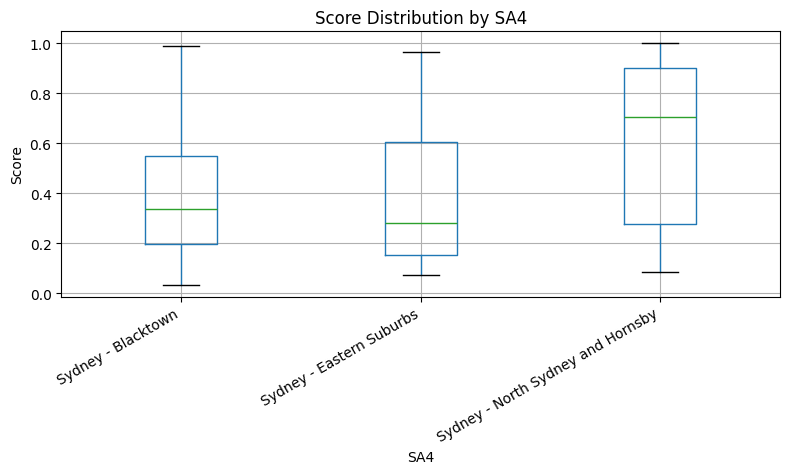

<Figure size 800x800 with 0 Axes>

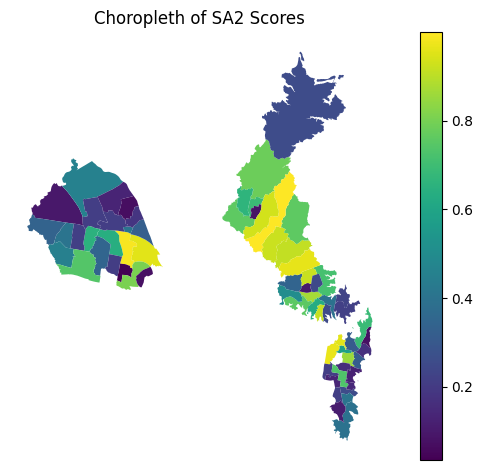

In [58]:
sql = """
SELECT a.sa2_code21,
       a.sa2_name21,
       a.geometry,
       s.sa4_name21,
       s.score
FROM raw.sa2_my AS a
JOIN analysis.sa2_scores AS s
  ON a.sa2_code21 = s.sa2_code21
"""
sa2_gdf = gpd.read_postgis(sql, con=engine, geom_col='geometry')

# Boxplot of SA2 score distribution within each SA4
fig, ax = plt.subplots(figsize=(8, 5))
sa2_gdf.boxplot(column='score', by='sa4_name21', ax=ax)
ax.set_title('Score Distribution by SA4')
ax.set_xlabel('SA4')
ax.set_ylabel('Score')
plt.suptitle('')               # removes the automatic “Boxplot grouped by …” subtitle
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# Choropleth map of SA2 scores
plt.figure(figsize=(8, 8))
sa2_gdf.plot(column='score', legend=True)
plt.title('Choropleth of SA2 Scores')
plt.axis('off')
plt.tight_layout()
plt.show()


Correlation matrix of components vs. z_total:
             z_business   z_stops     z_poi  z_schools   z_total
z_business    1.000000 -0.227673 -0.010814   0.167238  0.486484
z_stops      -0.227673  1.000000  0.605080  -0.452004  0.484731
z_poi        -0.010814  0.605080  1.000000  -0.259478  0.699168
z_schools     0.167238 -0.452004 -0.259478   1.000000  0.238727
z_total       0.486484  0.484731  0.699168   0.238727  1.000000 



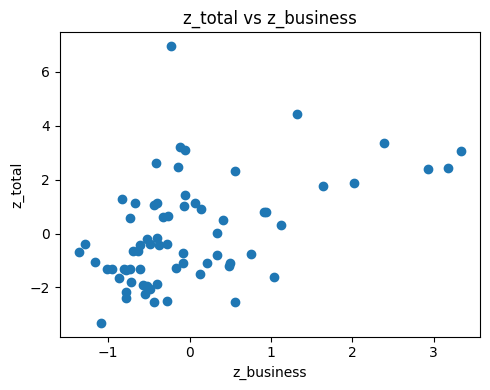

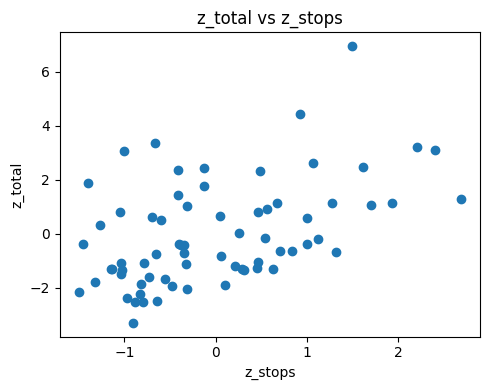

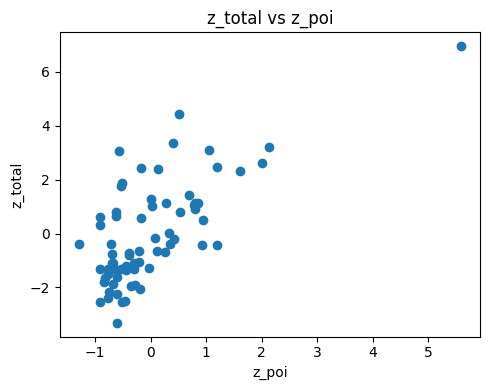

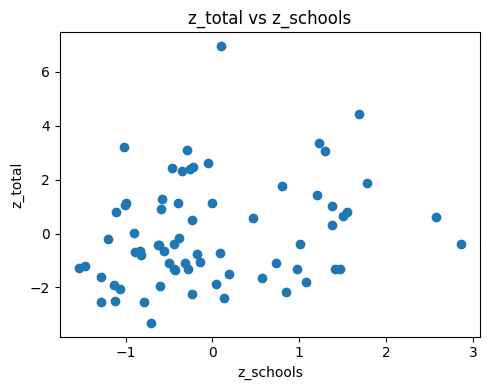

In [59]:
# 1) Pull the z-scores and the total from Postgres
df_comp = pd.read_sql_query("""
    SELECT 
      z_business,
      z_stops,
      z_poi,
      z_schools,
      z_total
    FROM analysis.sa2_scores
""", con=engine)

# 2) Compute the correlation matrix
corr = df_comp.corr()
print("Correlation matrix of components vs. z_total:\n", corr, "\n")

# 3) Scatter-plots of each component against z_total
for comp in ['z_business','z_stops','z_poi','z_schools']:
    plt.figure(figsize=(5,4))
    plt.scatter(df_comp[comp], df_comp['z_total'])
    plt.xlabel(comp)
    plt.ylabel('z_total')
    plt.title(f'z_total vs {comp}')
    plt.tight_layout()
    plt.show()


score            float64
median_income      int64
mean_income        int64
dtype: object


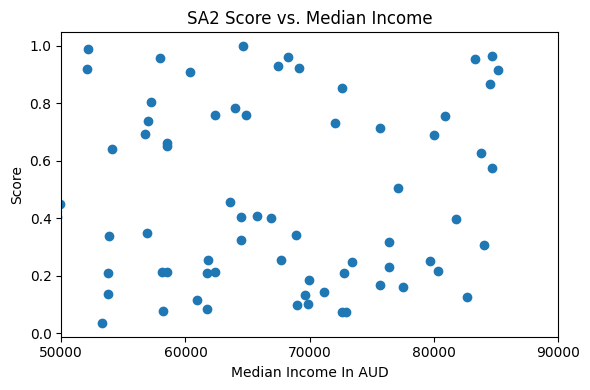

Pearson r = 0.038


In [ ]:
# Step 5: Correlation with Median Income (using pandas corr)
df_inc = pd.read_sql_query("""
    SELECT
      s.score,
      -- cast the text fields to numeric
      i.median_income::integer    AS median_income,
      i.mean_income::integer      AS mean_income
    FROM analysis.sa2_scores AS s
    LEFT JOIN raw.income_my AS i
      ON s.sa2_code21::bigint = i.sa2_code21
""", con=engine)


# 5.1 scatter-plot: score vs income with fixed numeric ticks & limits
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df_inc['median_income'], df_inc['score'])
ax.set_xlabel('Median Income In AUD')
ax.set_ylabel('Score')
ax.set_title('SA2 Score vs. Median Income')

# set fixed ticks at 50000, 60000, …, 90000
ticks = list(range(50_000, 100_000, 10_000))
ax.set_xticks(ticks)
ax.set_xticklabels([str(t) for t in ticks], rotation=0)

# force the x-axis to span [50000,90000]
ax.set_xlim(50_000, 90_000)

plt.tight_layout()
plt.show()

# 5.2 Pearson’s r
r = df_inc['median_income'].corr(df_inc['score'])
print(f"Pearson r = {r:.3f}")


In [51]:

# 1. Read the entire sa2_scores table
df_scores = pd.read_sql_query(
    "SELECT * FROM analysis.sa2_scores",
    con=engine
)

# 2. Export to CSV (in your working directory)
df_scores.to_csv("sa2_scores.csv", index=False)

print("✅ Exported analysis.sa2_scores → sa2_scores.csv")


✅ Exported analysis.sa2_scores → sa2_scores.csv
